In [1]:
# Forecasting years, number of years to use for out-of-sample 
# evaluation (We will create one forecast per country for each year
# which we compare to the actual GDP)
nyears = 10
# Number of lags to use for GP regression
lags = 5
# Indicator labels and names in the World Bank API
indicators  = {"gdp"        : "NY.GDP.MKTP.CD",
               "population" :    "SP.POP.TOTL",
               "inflation"  : "FP.CPI.TOTL.ZG"}
nindicators = len(indicators)
# The variable to forecast, should be one of the indicator labels
target_variable = "gdp"
# Countries to include in the data, specified as ISO country codes
countries  = ['au','ca','de','es','fr','gb','jp','us']
ncountries = len(countries)
# Start and end year for the data set
start_year = 1976
end_year   = 2016

In [2]:
#the package requests is to download some macroeconomic
#indicatores from the World Bank HTTP API

We specify a template url that we fill in with the different countries, indicators and dates that we specified in the configuration above. When we request the URL the HTTP API will respond with the selected data. The data is fetched in json format, which we loop over and put in a pandas data frame.

In [3]:
import pandas as pd
import requests

In [4]:
template_url = "http://api.worldbank.org/v2/countries/{0}/indi"
template_url +="cators/{1}?date={2}:{3}&format=json&per_page=999"

In [5]:
# Countries should be ISO identifiers separated by semi-colon
country_str = ';'.join(countries)

raw_data =pd.DataFrame()

In [6]:
raw_data

""


In [7]:
for label, indicator in indicators.items():
# Fill in the template URL
    url = template_url.format(country_str, indicator, 
                                  start_year, end_year)
    
    # Request the data
    json_data = requests.get(url)
    
    # Convert the JSON string to a Python object
    json_data = json_data.json()
    
    # The result is a list where the first element is meta-data, 
    # and the second element is the actual data
    json_data = json_data[1]
    
    # Loop over all data points, pick out the values and append 
    # them to the data frame
    for data_point in json_data:
        
        country = data_point['country']['id']
        
        # Create a variable for each country and indicator pair
        item    = country + '_' + label
        
        year    = data_point['date']
        
        value   = data_point['value']
        
        # Append to data frame
        new_row  = pd.DataFrame([[item, year, value]],
                                columns=['item', 'year', 'value'])
        raw_data = raw_data.append(new_row)
# Pivot the data to get unique years along the columns,
# and variables along the rows
raw_data = raw_data.pivot('year', 'item', 'value')
# Let's look at the first few rows and columns
print('\n', raw_data.iloc[:10, :5], '\n')


 item        AU_gdp  AU_inflation  AU_population        CA_gdp  CA_inflation
year                                                                       
1976  1.049212e+11     13.322884     14033000.0  2.065756e+11      7.541739
1977  1.102019e+11     12.309820     14192000.0  2.116122e+11      7.976445
1978  1.183386e+11      8.004926     14358000.0  2.186329e+11      8.973723
1979  1.347120e+11      9.122007     14514000.0  2.430721e+11      9.144677
1980  1.497760e+11     10.135841     14692000.0  2.738538e+11     10.129221
1981  1.766423e+11      9.487666     14927000.0  3.062149e+11     12.471612
1982  1.937703e+11     11.351820     15178000.0  3.135065e+11     10.768972
1983  1.770304e+11     10.038911     15369000.0  3.405477e+11      5.863588
1984  1.932422e+11      3.960396     15544000.0  3.553726e+11      4.304778
1985  1.802355e+11      6.734694     15758000.0  3.647565e+11      3.962031 



In [8]:
import matplotlib.pyplot as plt

In [9]:
indicators.keys()

dict_keys(['gdp', 'population', 'inflation'])

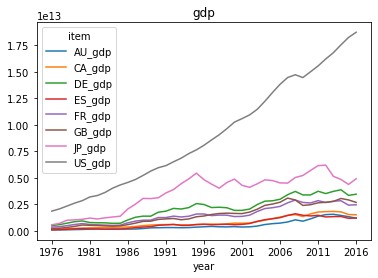

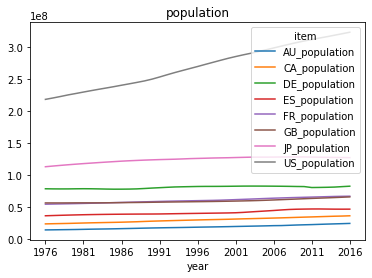

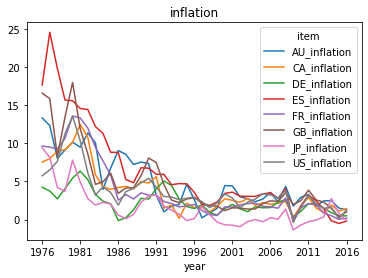

In [10]:
for lab in indicators.keys():
    indicator = raw_data[[x for x in raw_data.columns 
                              if x.split("_")[-1] == lab]]
    indicator.plot(title=lab)
    plt.show()

TRANSFORM THE DATA INTO A MORE SUITABLE FORMAT

In [11]:
import numpy as np

# Calculate rates of change instead of absolute levels
# (Runtime warning expected due to NaN)
data = np.log(raw_data).diff().iloc[1:,:]

#Set NaN to zero
data.fillna(0, inplace=True)

#Subtract the mean from each series
data = data - data.mean()

#Convert to data type
data.index = pd.to_datetime(data.index, format='%Y')

#Put the target variable into a separate data frame

target = data[[x for x in data.columns
              if x.split("_")[-1] == target_variable]]


C:\Users\User\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [12]:
#let's see how three different models perform

BASELINE FORECASTS

We will first establish the performance of a simple baseline method, which will be used as a comparison to subsequent methods. Our baseline method will simply predict the same rate of change as the previous observation of the target variable.

In [13]:
errors = target.iloc[-nyears:] - target.shift().iloc[-nyears:]

# Root mean squared error
rmse = errors.pow(2).sum().sum()/(nyears*ncountries)**.5
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.1281 |
	------------------



MULTIVARIATE TIME SERIES (VAR)


Also termed a Vector Autoregression (VAR) in econometrics. To fit the model we use the statsmodels package, whose VAR implementation uses least squares to estimate the parameters. We train the model using one lag, i.e. regressing the target variable on the most recent previous values of the independent variables, but automatic methods to choose the number of lags are also supported in the statsmodels package, such as the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC). 


In [15]:
from statsmodels.tsa.api import VAR

# Sum of squared errors
sse = 0
for t in range(nyears):
    
    # Create a VAR model
    model = VAR(target.iloc[t:-nyears+t], freq='AS')
    
    # Estimate the model parameters
    results = model.fit(maxlags=1)
    
    actual_values = target.values[-nyears+t+1]
    
    forecasts = results.forecast(target.values[:-nyears+t], 1)
    forecasts = forecasts[0,:ncountries]
sse += ((actual_values - forecasts)**2).sum()
# Root mean squared error
rmse = (sse / (nyears * ncountries))**.5   #** in python is the exponential, here is the root square
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.0591 |
	------------------



GAUSSIAN PROCESS REGRESSION



In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
# We set the parameter of the covariance function to
# approximately equal to the median distance between data points,
# a common heuristic for this covariance function. The 'alpha' 
# argument is the noise variance, which we set equal to the 
# covariance parameter.
gpr = GaussianProcessRegressor(kernel=RBF(0.1), alpha=0.1)
# Number of data points for estimation/fitting for each forecast
ndata = target.shape[0] - nyears - lags
# Sum of squared errors
sse = 0
for t in range(nyears):
    
    # Observations for the target variables
    y = np.zeros((ndata, ncountries))
# Observations for the independent variables
    X = np.zeros((ndata, lags*ncountries*nindicators))
    
    for i in range(ndata):
        
        y[i] = target.iloc[t+i+1]
        X[i] = data.iloc[t+i+2:t+i+2+lags].values.flatten()
        
    gpr.fit(X, y)
    
    x_test   = np.expand_dims(data.iloc[t+1:t+1+lags].values.flatten(), 0)
    forecast = gpr.predict(x_test)
    
    sse += ((target.iloc[t].values - forecast)**2).sum()
    
rmse = (sse / (nyears * ncountries))**.5
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.1214 |
	------------------

